In [1]:
using DrWatson
@quickactivate "BayesWorkshop2021"
include(joinpath(srcdir(), "setup.jl"));

## Modeling count data with the Negative Binomial

When we considered modelling the data using a Poisson, we saw that the model didn't appear to fit as well to the data as we would like. In particular the model underpredicted low and high numbers of complaints, and overpredicted the medium number of complaints. This is one indication of over-dispersion, where the variance is larger than the mean. A Poisson model doesn't fit over-dispersed count data very well because the same parameter $\lambda$, controls both the expected counts and the variance of these counts. The natural alternative to this is the negative binomial model:

$$
\begin{align*}
\text{complaints}_{b,t} & \sim \text{Neg-Binomial}(\lambda_{b,t}, \phi) \\
\lambda_{b,t} & = \exp{(\eta_{b,t})} \\
\eta_{b,t} &= \alpha + \beta \, {\rm traps}_{b,t} + \beta_{\rm super} \, {\rm super}_{b} + \text{log_sq_foot}_{b}
\end{align*}
$$

In Stan the negative binomial mass function we'll use is called  $\texttt{neg_binomial_2_log}(\text{ints} \, y, \text{reals} \, \eta, \text{reals} \, \phi)$  in Stan. Like the `poisson_log` function, this negative binomial mass function that is parameterized in terms of its log-mean, $\eta$, but it also has a precision $\phi$ such that

$$
\mathbb{E}[y] \, = \lambda = \exp(\eta)
$$

$$
\text{Var}[y] = \lambda + \lambda^2/\phi = \exp(\eta) + \exp(\eta)^2 / \phi.
$$


As $\phi$ gets larger the term $\lambda^2 / \phi$ approaches zero and so  the variance of the negative-binomial approaches $\lambda$, i.e., the negative-binomial gets closer and closer to the Poisson.

### Fake data fit: Multiple NB regression

We're going to generate one draw from the fake data model so we can use the data to fit our model and compare the known values of the parameters to the posterior density of the parameters.

Create a dataset to feed into the model.

Now we run our NB regression over the fake data and extract the samples to examine posterior predictive checks and to check whether we've sufficiently recovered our known parameters, $\text{alpha}$ $\texttt{beta}$, .

In [2]:
using Turing

function NegativeBinomial2(μ, ϕ)
    p = 1 / (1 + μ / ϕ)
    r = ϕ

    return NegativeBinomial(r, p)
end

@model function multiple_NB_regression(; traps, live_in_super, log_sq_foot, complaints=missing)
    alpha ~ Normal(log(4), 1)
    beta ~ Normal(-0.25, 1)
    beta_super ~ Normal(-0.5, 1)
    inv_phi ~ truncated(Normal(1), 0, Inf)

    # Allocate if we're going to sample.
    complaints = complaints === missing ? Vector{Int}(undef, length(traps)) : complaints
    @. complaints ~ NegativeBinomial2(
        exp(alpha + beta * traps + beta_super * live_in_super + log_sq_foot),
        inv(inv_phi)
    )
    return (; alpha, beta, beta_super, inv_phi, complaints)
end

multiple_NB_regression (generic function with 1 method)

Construct the vector of true values from your simulated dataset and compare to the recovered parameters.

In [3]:
N = size(pest_data, 1)
mean_traps = mean(pest_data.traps)
fake_traps = rand(filldist(Poisson(mean_traps), N))
fake_obs = (traps = fake_traps,
    live_in_super = rand(filldist(Bernoulli(0.5), N)),
    log_sq_foot = rand(filldist(Normal(1.5, 0.1), N)),
)

(traps = [10, 12, 10, 8, 5, 5, 9, 6, 7, 6  …  6, 13, 6, 12, 6, 9, 11, 4, 3, 4], live_in_super = Bool[1, 0, 1, 0, 1, 0, 0, 0, 1, 0  …  0, 0, 1, 0, 0, 0, 0, 0, 0, 1], log_sq_foot = [1.5402399979843977, 1.5425372056256093, 1.381070692832613, 1.511630975757052, 1.3655027131290263, 1.5426339439792278, 1.4216374618172534, 1.564843269867859, 1.482344540326858, 1.3720762963614122  …  1.4073903410521562, 1.473716453712855, 1.5328542358768633, 1.384630700443407, 1.527035364320064, 1.4250473961493295, 1.5810103406221736, 1.5153265545632197, 1.3676119778291342, 1.36799427864984])

In [4]:
fake_data = multiple_NB_regression(; fake_obs...)()

(alpha = -0.052116075988608346, beta = -1.0962183844128301, beta_super = 1.1400967968463014, inv_phi = 3.313037903759713, complaints = [0, 0, 0, 0, 1, 1, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [5]:
fake_post = sample(multiple_NB_regression(; fake_obs..., complaints=fake_data.complaints), NUTS(), 1_000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/tor/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47

Chains MCMC chain (1000×16×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 21.19 seconds
Compute duration  = 21.19 seconds
parameters        = beta_super, alpha, beta, inv_phi
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

       alpha    0.2611    0.9169     0.0290    0.0525   243.9371    1.0031     ⋯
        beta   -0.9878    0.2334     0.0074    0.0128   237.5797    1.0081     ⋯
  beta_super    0.3406    0.7250     0.0229    0.0312   419.0547    0.9994     ⋯
     inv_phi    1.6165    0.7824     0.0247    0.0309   382.2201    0.9993     ⋯
                                        

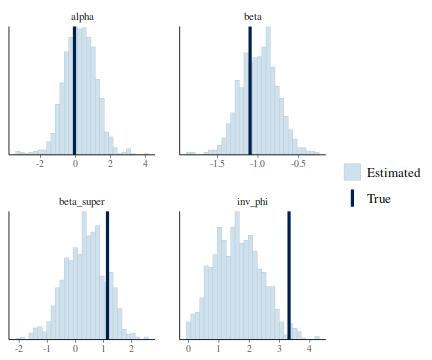

RObject{VecSxp}


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/tor/.julia/packages/RCall/iMDW2/src/io.jl:160


In [6]:
mcmc_recover_hist(
    fake_post,
    (
        alpha = fake_data.alpha,
        beta = fake_data.beta,
        beta_super = fake_data.beta_super,
        inv_phi = fake_data.inv_phi
    )
)

### Fit to real data and check the fit

In [7]:
# Add the `log_sq_foot` as in 02.
transform!(pest_data, :total_sq_foot => ByRow(total_sq_foot -> log(total_sq_foot / 1e4)) => :log_sq_foot)

obs = (
    traps = pest_data.traps,
    live_in_super = pest_data.live_in_super,
    log_sq_foot = pest_data.log_sq_foot
)
post = sample(multiple_NB_regression(; obs..., complaints=pest_data.complaints), NUTS(), 1_000)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/tor/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (1000×16×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 1.2 seconds
Compute duration  = 1.2 seconds
parameters        = beta_super, alpha, beta, inv_phi
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

       alpha    1.3503    0.3994     0.0126    0.0231   367.5036    1.0007     ⋯
        beta   -0.2305    0.0518     0.0016    0.0027   392.2108    0.9997     ⋯
  beta_super   -0.3047    0.2195     0.0069    0.0117   538.7121    1.0007     ⋯
     inv_phi    0.6724    0.1404     0.0044    0.0051   654.6528    1.0013     ⋯
                                            

Let's look at our predictions vs. the data.

In [8]:
yrep = posterior_predictive(multiple_NB_regression(; obs...), post)

1000-element Vector{NamedTuple{(:complaints,), Tuple{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}:
 (complaints = [0.0, 1.0, 0.0, 2.0, 0.0, 4.0, 0.0, 0.0, 0.0, 7.0  …  2.0, 13.0, 7.0, 13.0, 15.0, 11.0, 10.0, 8.0, 5.0, 22.0],)
 (complaints = [3.0, 2.0, 2.0, 3.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0  …  4.0, 8.0, 5.0, 5.0, 0.0, 15.0, 11.0, 12.0, 5.0, 39.0],)
 (complaints = [4.0, 1.0, 6.0, 4.0, 2.0, 0.0, 5.0, 0.0, 12.0, 3.0  …  5.0, 5.0, 1.0, 1.0, 1.0, 2.0, 8.0, 2.0, 4.0, 17.0],)
 (complaints = [2.0, 1.0, 1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 1.0, 2.0  …  2.0, 3.0, 1.0, 6.0, 2.0, 6.0, 3.0, 11.0, 4.0, 33.0],)
 (complaints = [2.0, 1.0, 0.0, 5.0, 11.0, 1.0, 1.0, 0.0, 3.0, 2.0  …  1.0, 9.0, 23.0, 16.0, 4.0, 11.0, 2.0, 3.0, 3.0, 0.0],)
 (complaints = [6.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, 1.0  …  5.0, 15.0, 5.0, 6.0, 1.0, 12.0, 7.0, 17.0, 43.0, 29.0],)
 (complaints = [7.0, 8.0, 2.0, 2.0, 1.0, 0.0, 5.0, 5.0, 0.0, 4.0  …  2.0, 1.0, 2.0, 7.0, 3.0, 15.0, 7.0, 

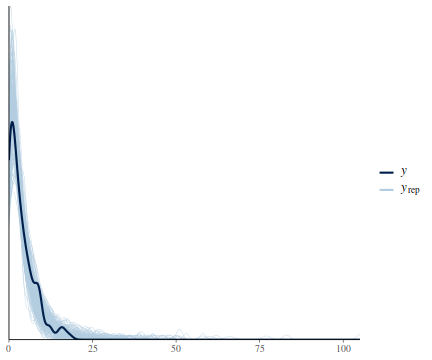

RObject{VecSxp}


In [9]:
ppc_dens_overlay(pest_data.complaints, yrep[1:200])

It appears that our model now captures both the number of small counts better as well as the tails.

Let's check if the negative binomial model does a better job capturing the number of zeros:

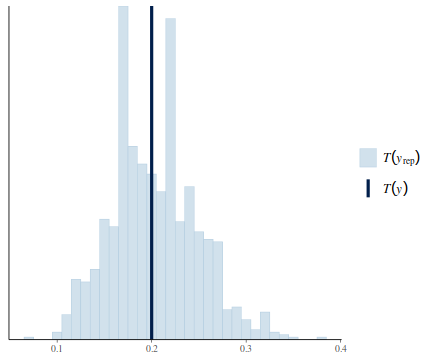

RObject{VecSxp}


In [10]:
using RCall
ggplot = rimport("ggplot2")

ppc_stat(pest_data.complaints, yrep, stat = R"function(x) mean(x == 0)", binwidth = 0.01)

These look OK, but let's look at the standardized residual plot.

In [11]:
# Convert into a matrix of size `(num_variables, num_samples)`
yrep_matrix = mapreduce(hcat, yrep) do y
    y.complaints
end;

qqnorm(dropdims(mean(yrep_matrix; dims=2); dims=2), qqline=:R)

LoadError: UndefVarError: qqnorm not defined

Looks OK, but we still have some very large *standardized* residuals. This might be because we are currently ignoring that the data are clustered by buildings, and that the probability of roach issue may vary substantially across buildings.

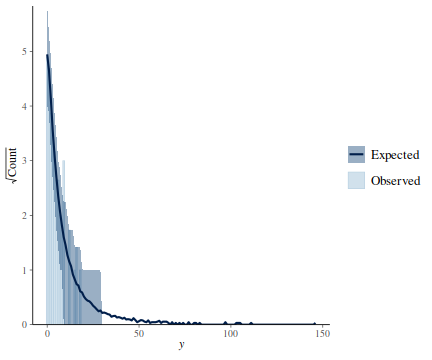

RObject{VecSxp}


In [12]:
ppc_rootogram(pest_data.complaints, yrep)

The rootogram now looks much more plausible. We can tell this because now the expected number of complaints matches much closer to the observed number of complaints. However, we still have some larger counts that appear to be outliers for the model.

Check predictions by number of traps:

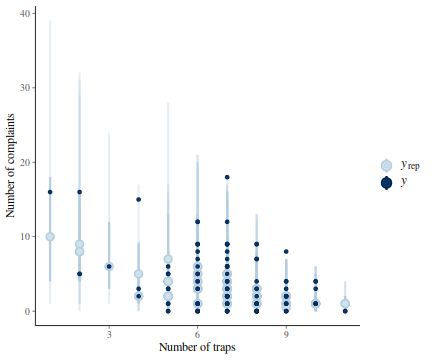

RObject{VecSxp}


In [13]:
ppc_intervals(pest_data.complaints, yrep, x = pest_data.traps) + ggplot.labs(x = "Number of traps", y = "Number of complaints")

We haven't used the fact that the data are clustered by building yet. A posterior predictive check might elucidate whether it would be a good idea to add the building information into the model.

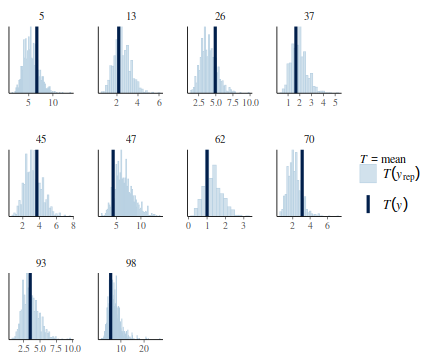

RObject{VecSxp}


In [14]:
ppc_stat_grouped(
  pest_data.complaints,
  yrep,
  group = pest_data.building_id,
  stat = "mean",
  binwidth = 0.2
)

We're getting plausible predictions for most building means but some are estimated better than others and some have larger uncertainties than we might expect. If we explicitly model the variation across buildings we may be able to get much better estimates.